In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import segyio
import pickle
from math import floor
from seysmo.data.make_dataset import find_files, calculate_distance, create_input_dict
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio
from seysmo.visualization.plotting import plot_map
from seysmo.features.mapping import do_array_for_mapping, compute_y_pred
from seysmo.models.utils import give_data

In [12]:
with open('../../data/processed/Area1.pkl', 'rb') as f:
    data_coord = pickle.load(f)

In [13]:
seysm = list(data_coord.values())


In [14]:
seysm[1059][0]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.01730523,
         0.00239133, -0.01193942],
       [ 0.        ,  0.        ,  0.        , ...,  0.03622174,
         0.03437769,  0.02680001],
       [ 0.        ,  0.        ,  0.        , ..., -0.00123487,
         0.01179506,  0.02245822]], dtype=float32)

In [15]:
def calculate_mse(v1, v2):
    return np.mean((v1 - v2) ** 2)

min_mse = float('inf')
max_mse = 0
min_pair = None
max_pair = None

for i in range(1, len(seysm)):
    v1 = seysm[i][1]
    v2 = seysm[0][1]
    mse = calculate_mse(v1, v2)
        
    if mse < min_mse:
        min_mse = mse
        min_pair = seysm[i]
    if mse > min_mse:
        max_mse = mse
        max_pair = seysm[i]
    

print(f"Пара с минимальной MSE: {min_pair}, минимальная MSE: {min_mse}")

Пара с минимальной MSE: (array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.01058413,
         0.01855092,  0.02419173],
       [ 0.        ,  0.        ,  0.        , ..., -0.0173385 ,
        -0.00857416,  0.00200096],
       [ 0.        ,  0.        ,  0.        , ..., -0.02307981,
        -0.02764093, -0.0266332 ]], dtype=float32), array([155.467  , 204.783  , 323.42993, 347.05298, 403.7168 , 500.7649 ,
       608.0469 , 686.978  , 737.1919 , 769.656  ], dtype=float32)), минимальная MSE: 168.3518524169922


In [16]:
min_pair

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.01058413,
          0.01855092,  0.02419173],
        [ 0.        ,  0.        ,  0.        , ..., -0.0173385 ,
         -0.00857416,  0.00200096],
        [ 0.        ,  0.        ,  0.        , ..., -0.02307981,
         -0.02764093, -0.0266332 ]], dtype=float32),
 array([155.467  , 204.783  , 323.42993, 347.05298, 403.7168 , 500.7649 ,
        608.0469 , 686.978  , 737.1919 , 769.656  ], dtype=float32))

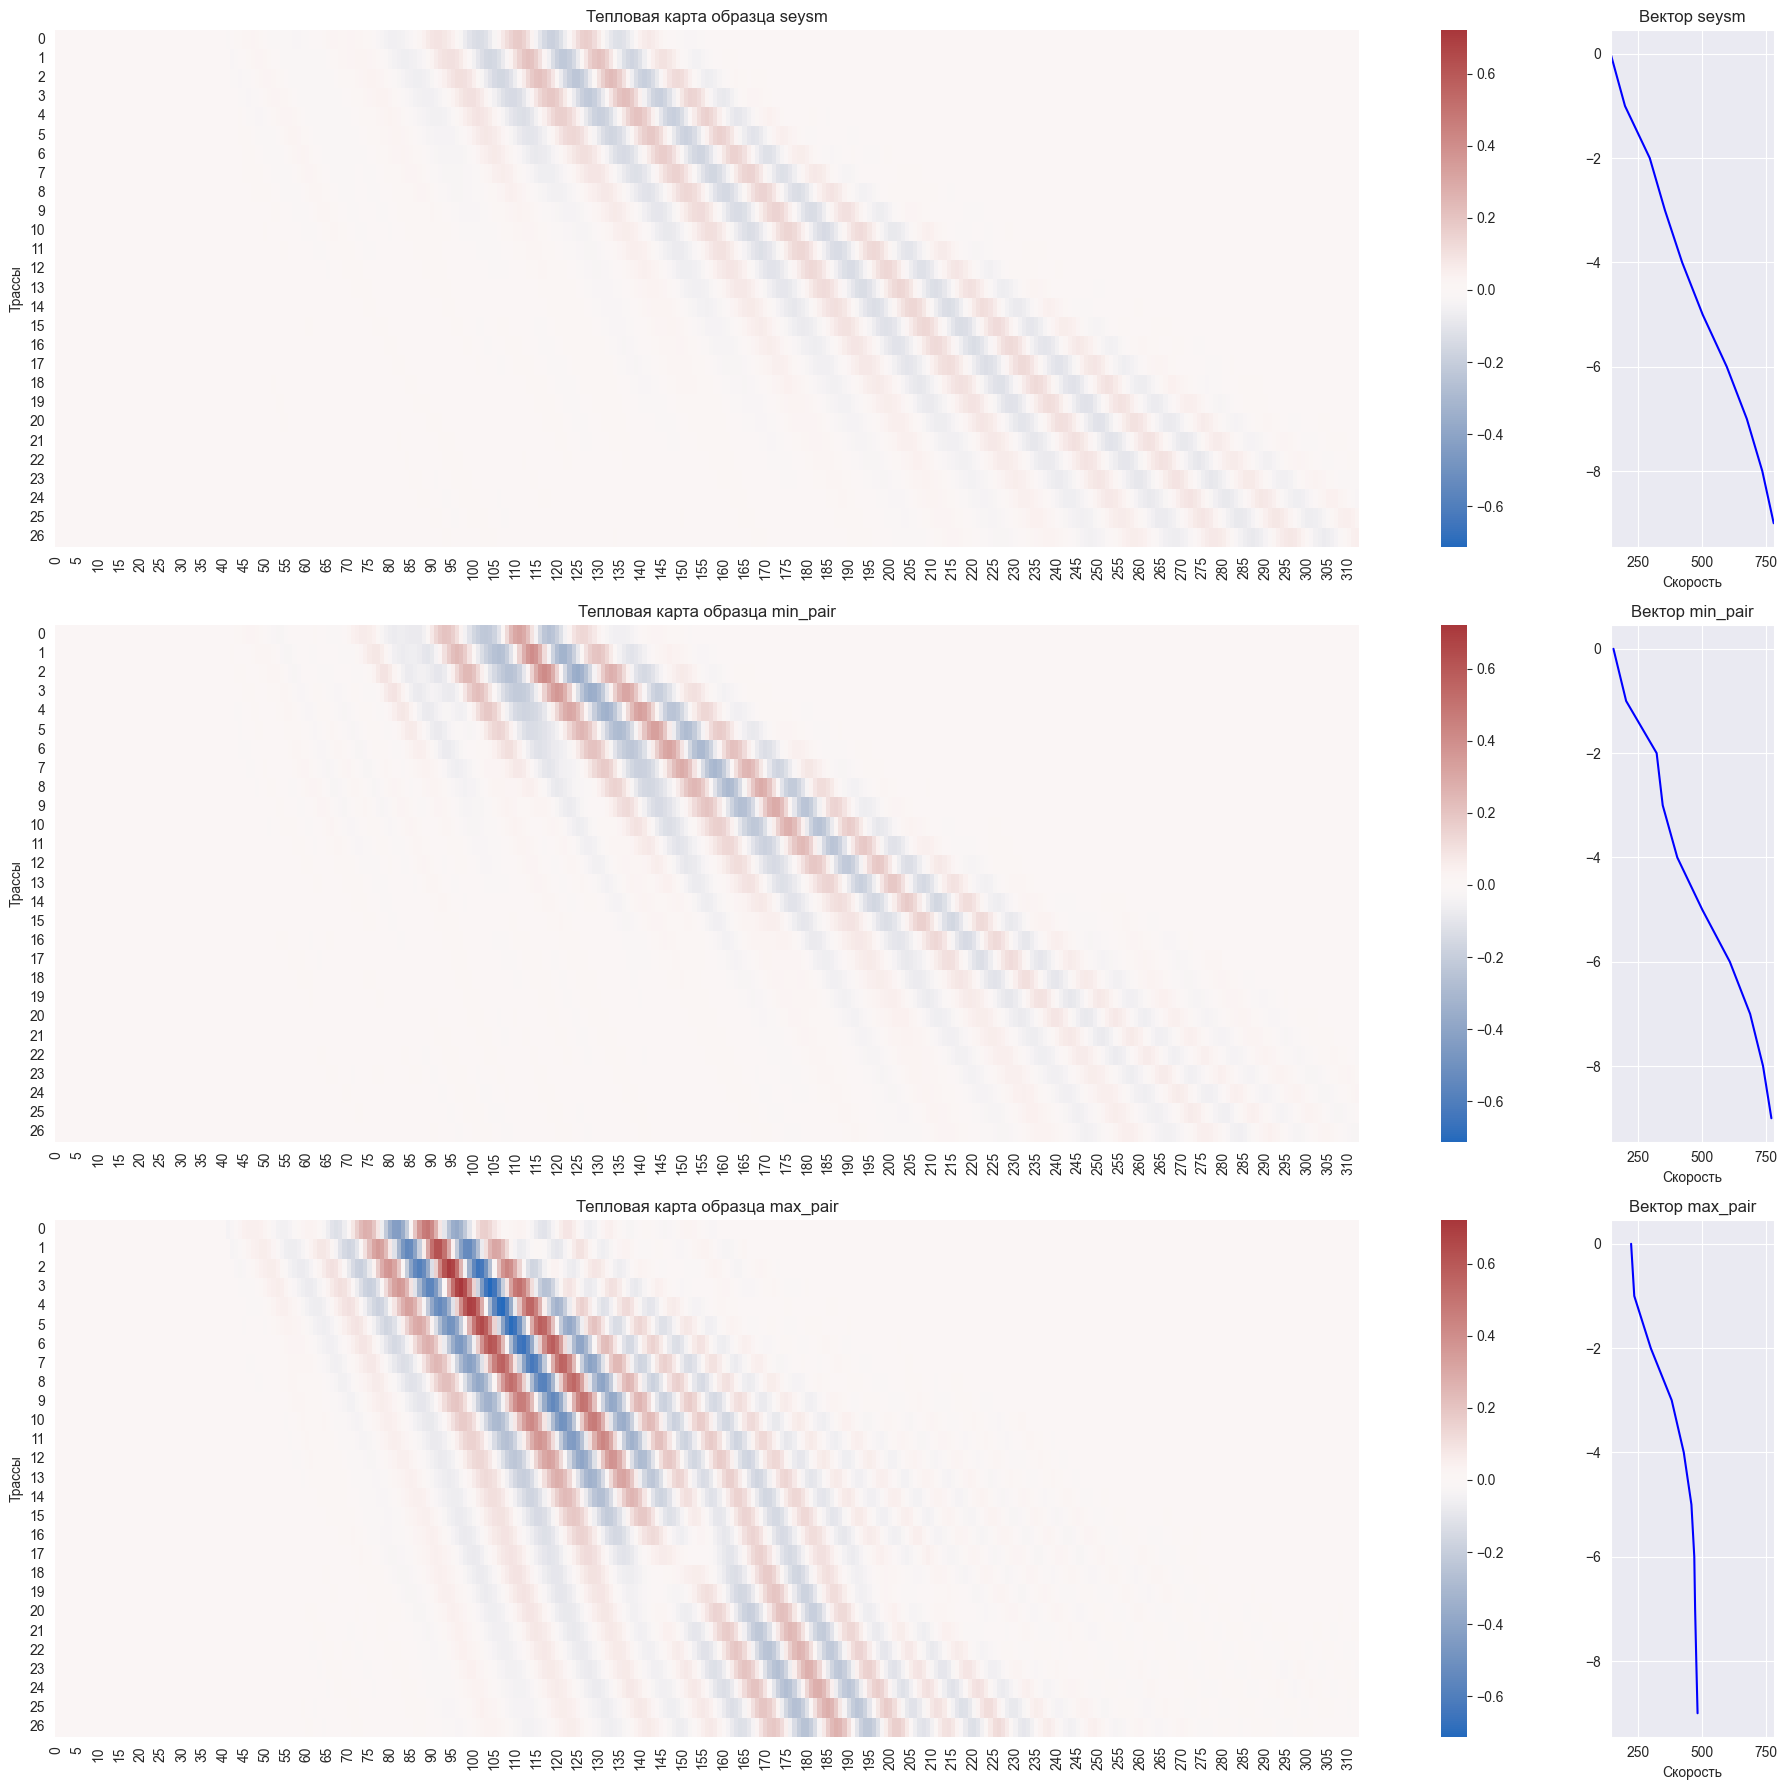

In [17]:
# Найдем минимальные и максимальные значения для цветовой карты
vmin = min(np.min(seysm[0][0]), np.min(min_pair[0]), np.min(max_pair[0]))
vmax = max(np.max(seysm[0][0]), np.max(min_pair[0]), np.max(max_pair[0]))

vec_min = min(np.min(seysm[0][1]), np.min(min_pair[1]), np.min(max_pair[1]))
vec_max = max(np.max(seysm[0][1]), np.max(min_pair[1]), np.max(max_pair[1]))

# Создаем фигуру с 3 рядами и 2 колонками
fig, axes = plt.subplots(3, 2, figsize=(18, 18), gridspec_kw={'width_ratios': [10, 1]})

# Визуализация для seysm
sns.heatmap(seysm[0][0], cmap="vlag", ax=axes[0, 0], vmin=vmin, vmax=vmax, cbar=True)
axes[0, 0].set_title('Тепловая карта образца seysm')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Трассы')

axes[0, 1].plot(seysm[0][1], -np.arange(len(seysm[0][1])), color='blue')
axes[0, 1].set_title('Вектор seysm')
axes[0, 1].set_xlim(vec_min, vec_max)
axes[0, 1].set_xlabel('Скорость')
axes[0, 1].set_ylabel('')

# Визуализация для min_pair
sns.heatmap(min_pair[0], cmap="vlag", ax=axes[1, 0], vmin=vmin, vmax=vmax, cbar=True)
axes[1, 0].set_title('Тепловая карта образца min_pair')
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Трассы')

axes[1, 1].plot(min_pair[1], -np.arange(len(min_pair[1])), color='blue')
axes[1, 1].set_title('Вектор min_pair')
axes[1, 1].set_xlim(vec_min, vec_max)
axes[1, 1].set_xlabel('Скорость')
axes[1, 1].set_ylabel('')

# Визуализация для max_pair
sns.heatmap(max_pair[0], cmap="vlag", ax=axes[2, 0], vmin=vmin, vmax=vmax, cbar=True)
axes[2, 0].set_title('Тепловая карта образца max_pair')
axes[2, 0].set_xlabel('')
axes[2, 0].set_ylabel('Трассы')

axes[2, 1].plot(max_pair[1], -np.arange(len(max_pair[1])), color='blue')
axes[2, 1].set_title('Вектор max_pair')
axes[2, 1].set_xlim(vec_min, vec_max)
axes[2, 1].set_xlabel('Скорость')
axes[2, 1].set_ylabel('')

# Применяем layout, чтобы компоненты не перекрывались
plt.tight_layout()

# Показываем графики
plt.show()

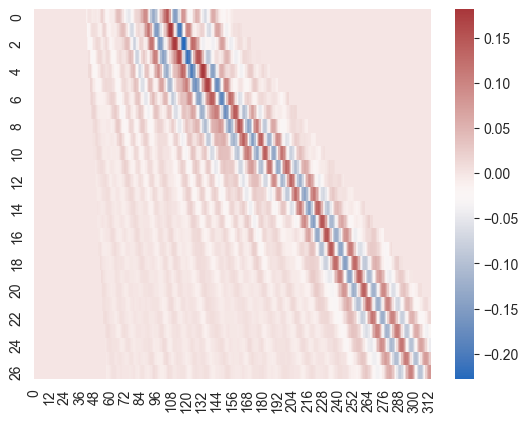

In [18]:
plt.figure()
sns.heatmap(seysm[0][0]-min_pair[0], cmap="vlag", cbar=True)
plt.show()

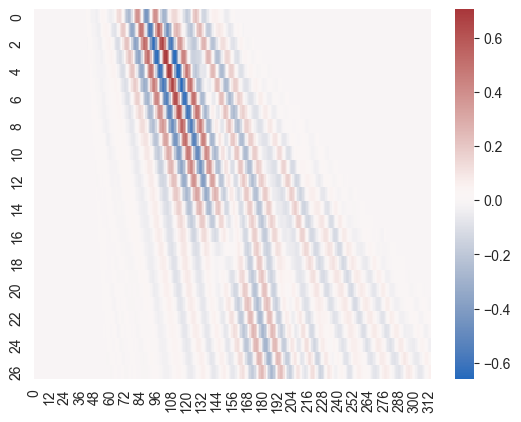

In [19]:
plt.figure()
sns.heatmap(seysm[0][0]-max_pair[0], cmap="vlag", cbar=True)
plt.show()

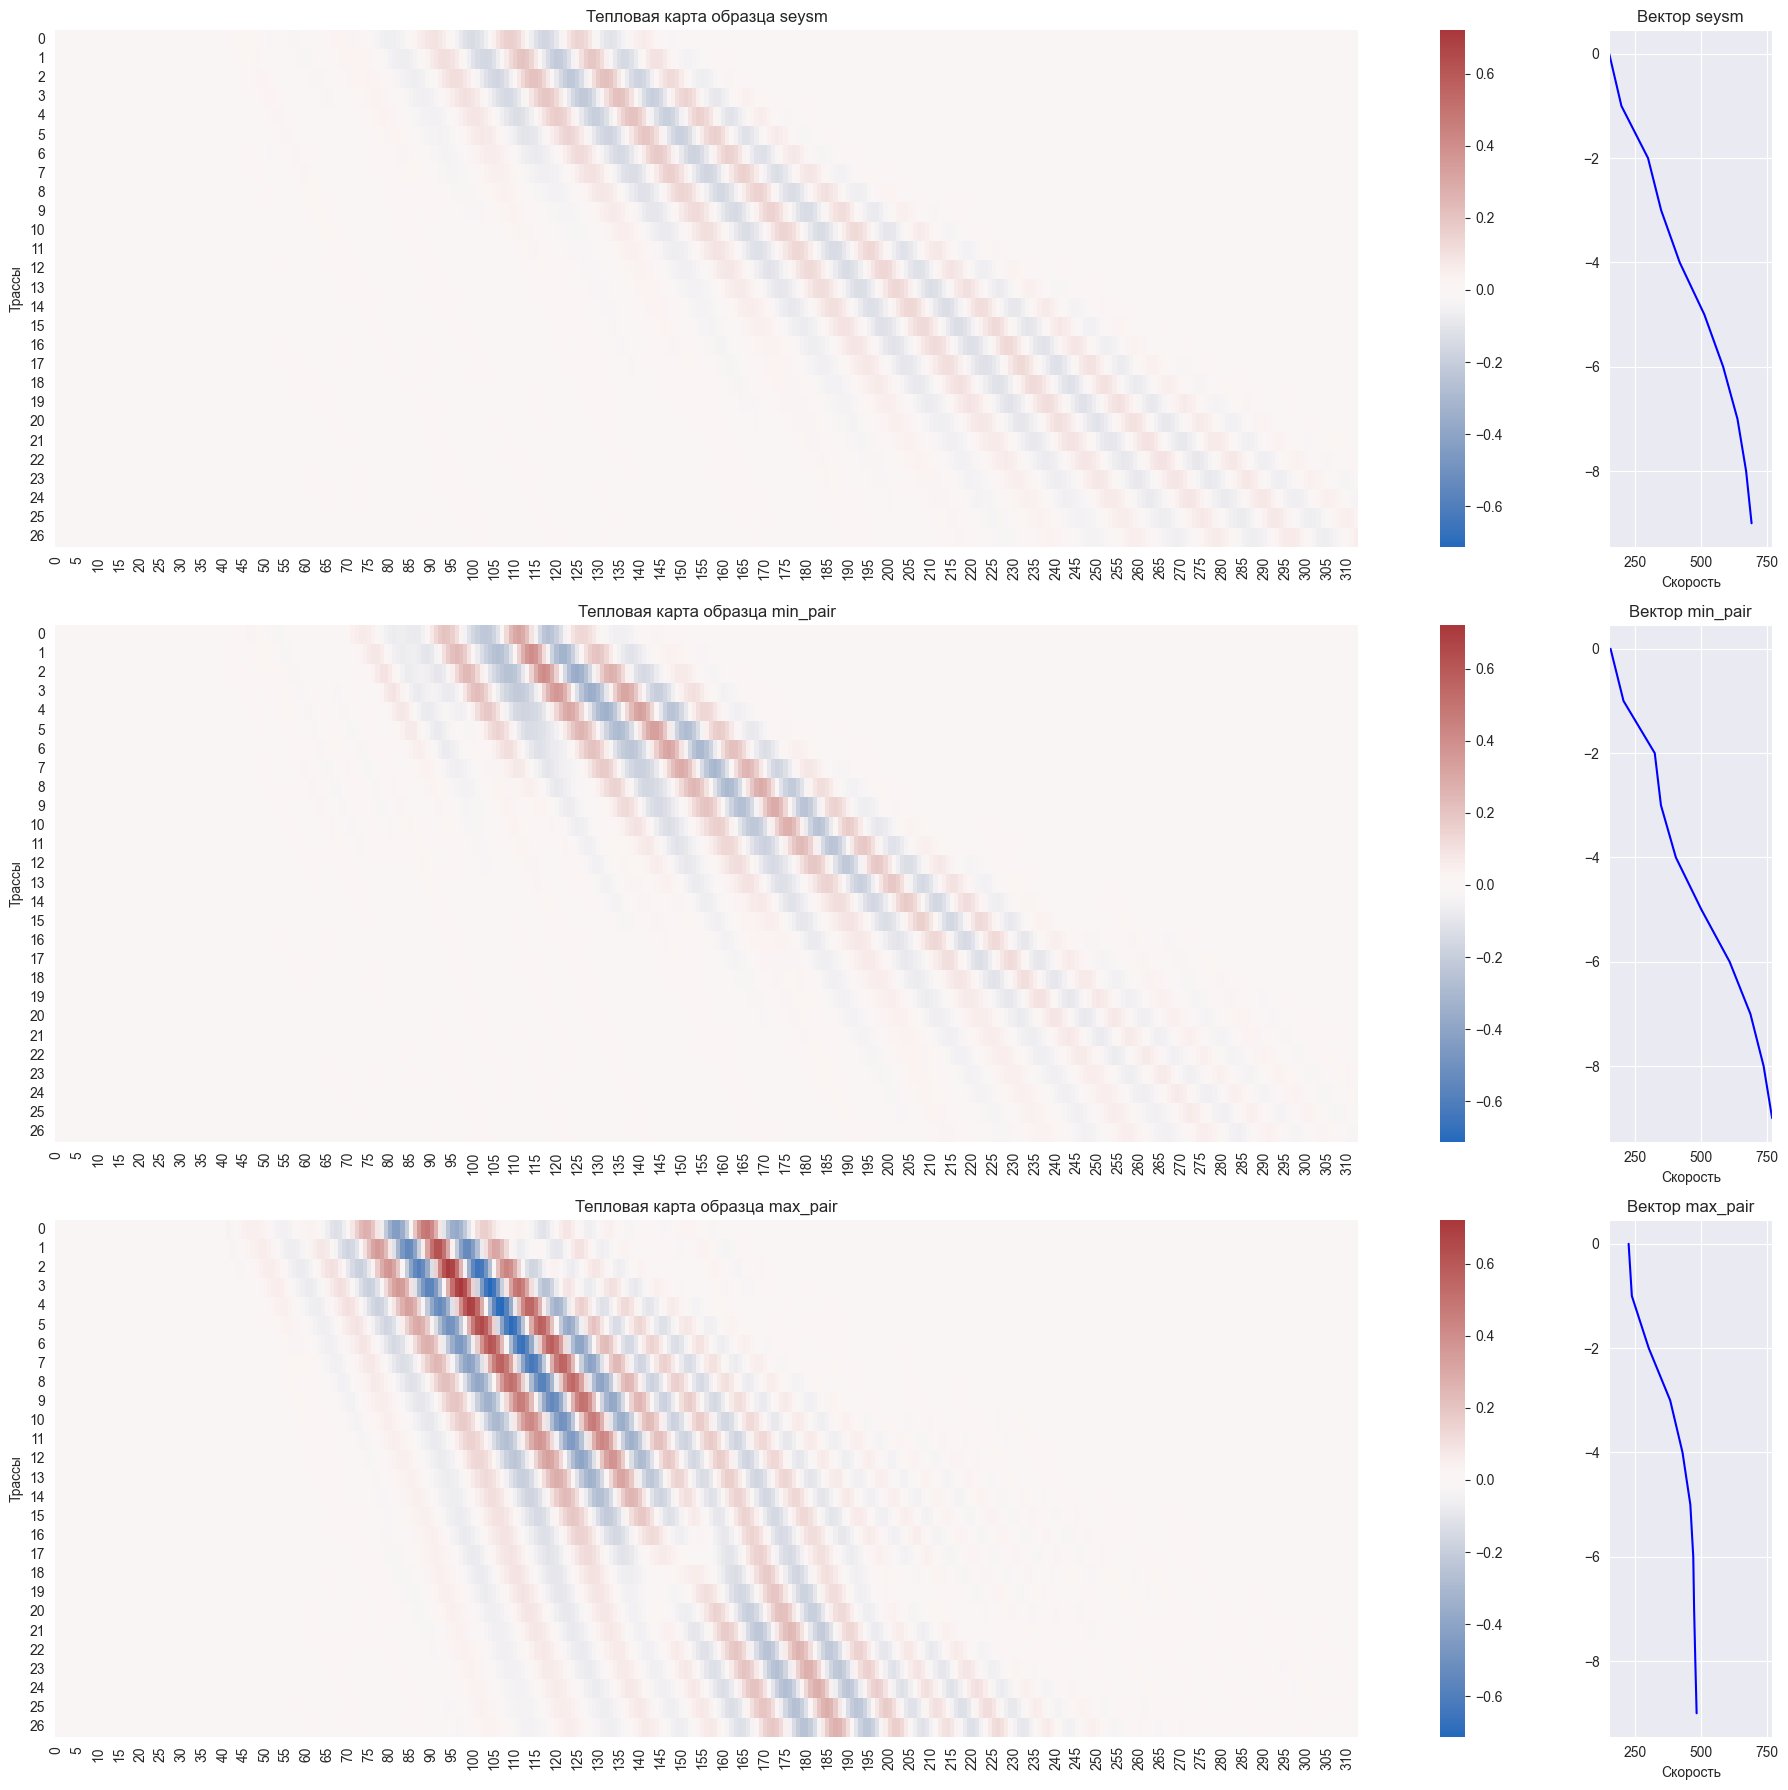

In [20]:
# Найдем минимальные и максимальные значения для цветовой карты
vmin = min(np.min(seysm[1][0]), np.min(min_pair[0]), np.min(max_pair[0]))
vmax = max(np.max(seysm[1][0]), np.max(min_pair[0]), np.max(max_pair[0]))

vec_min = min(np.min(seysm[1][1]), np.min(min_pair[1]), np.min(max_pair[1]))
vec_max = max(np.max(seysm[1][1]), np.max(min_pair[1]), np.max(max_pair[1]))

# Создаем фигуру с 3 рядами и 2 колонками
fig, axes = plt.subplots(3, 2, figsize=(18, 18), gridspec_kw={'width_ratios': [10, 1]})

# Визуализация для seysm
sns.heatmap(seysm[1][0], cmap="vlag", ax=axes[0, 0], vmin=vmin, vmax=vmax, cbar=True)
axes[0, 0].set_title('Тепловая карта образца seysm')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Трассы')

axes[0, 1].plot(seysm[1][1], -np.arange(len(seysm[0][1])), color='blue')
axes[0, 1].set_title('Вектор seysm')
axes[0, 1].set_xlim(vec_min, vec_max)
axes[0, 1].set_xlabel('Скорость')
axes[0, 1].set_ylabel('')

# Визуализация для min_pair
sns.heatmap(min_pair[0], cmap="vlag", ax=axes[1, 0], vmin=vmin, vmax=vmax, cbar=True)
axes[1, 0].set_title('Тепловая карта образца min_pair')
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Трассы')

axes[1, 1].plot(min_pair[1], -np.arange(len(min_pair[1])), color='blue')
axes[1, 1].set_title('Вектор min_pair')
axes[1, 1].set_xlim(vec_min, vec_max)
axes[1, 1].set_xlabel('Скорость')
axes[1, 1].set_ylabel('')

# Визуализация для max_pair
sns.heatmap(max_pair[0], cmap="vlag", ax=axes[2, 0], vmin=vmin, vmax=vmax, cbar=True)
axes[2, 0].set_title('Тепловая карта образца max_pair')
axes[2, 0].set_xlabel('')
axes[2, 0].set_ylabel('Трассы')

axes[2, 1].plot(max_pair[1], -np.arange(len(max_pair[1])), color='blue')
axes[2, 1].set_title('Вектор max_pair')
axes[2, 1].set_xlim(vec_min, vec_max)
axes[2, 1].set_xlabel('Скорость')
axes[2, 1].set_ylabel('')

# Применяем layout, чтобы компоненты не перекрывались
plt.tight_layout()

# Показываем графики
plt.savefig("../../reports/figures/heatmap.png")
plt.show()

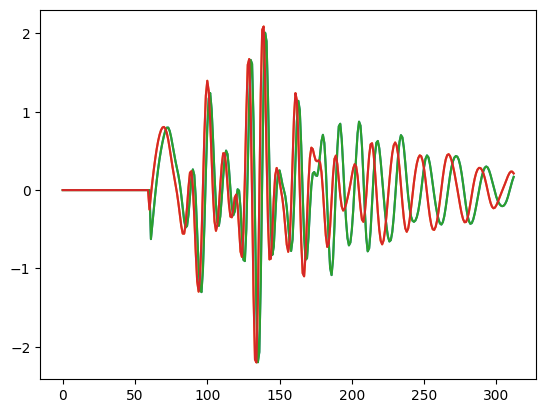

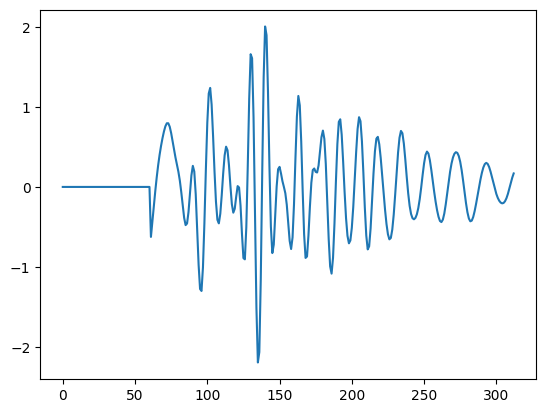

In [47]:
plt.plot(max_pair[0][26])

In [68]:
height = velo.reshape((29)) / (2*wl)
#height = 1/(wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*np.pi*wavefieldtransform.frequencies))
height

array([1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125, 2.25 , 2.375, 2.5  ,
       2.625, 2.75 , 2.875, 3.   , 3.125, 3.25 , 3.375, 3.5  , 3.625,
       3.75 , 3.875, 4.   , 4.125, 4.25 , 4.375, 4.5  , 4.625, 4.75 ,
       4.875, 5.   ])

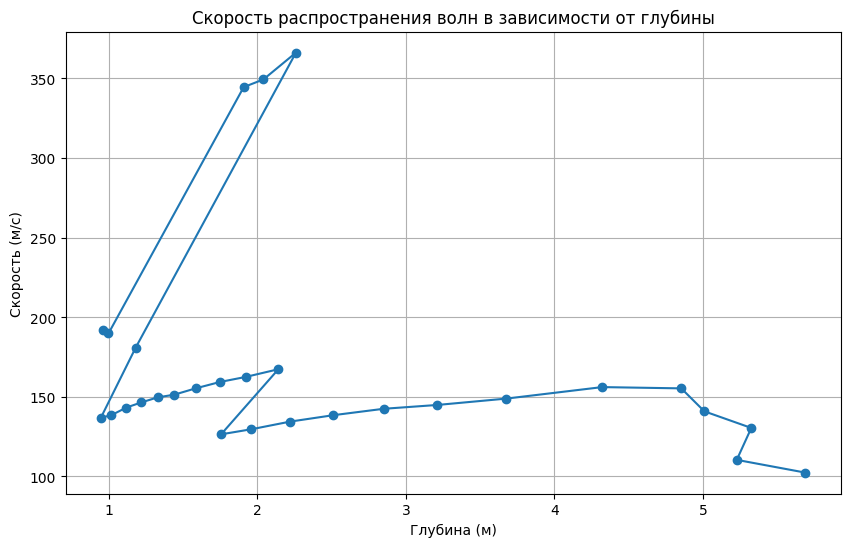

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(height, velo.reshape(29), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

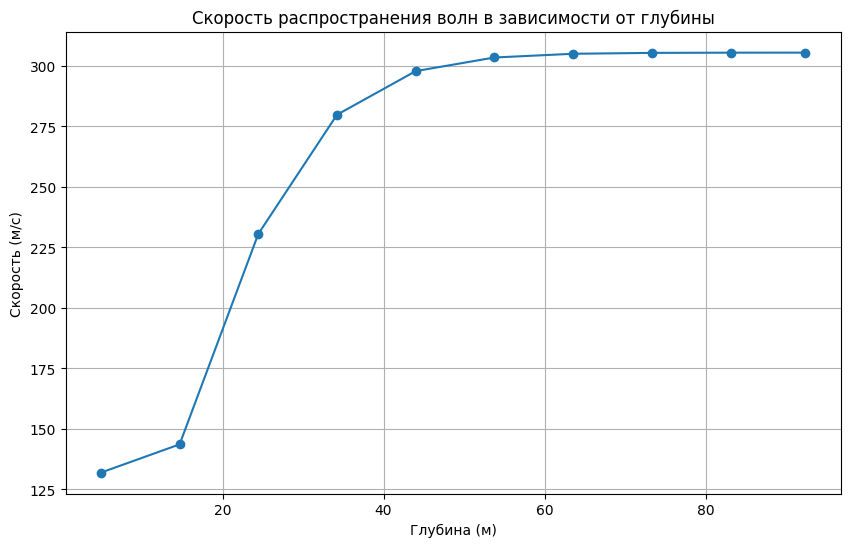

In [59]:
import pandas as pd

data = pd.read_csv(f"./Train_data/TXT/1.txt", delimiter="\t")
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

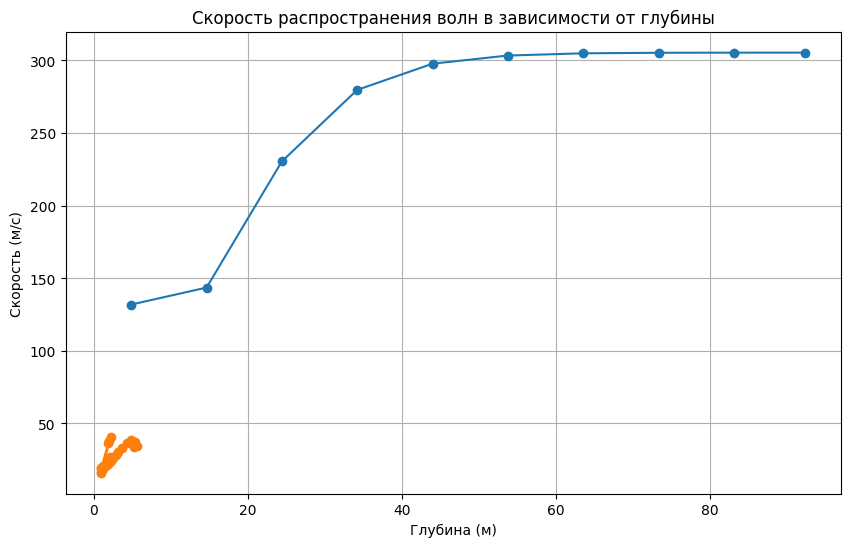

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wl, marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

In [17]:
freq = data['Velocity']/(2*data['Depth'])

In [18]:
freq

0    13.485478
1     4.893162
2     4.714061
3     4.086494
4     3.383045
5     2.820168
6     2.398381
7     2.081123
8     1.836797
9     1.652246
dtype: float64

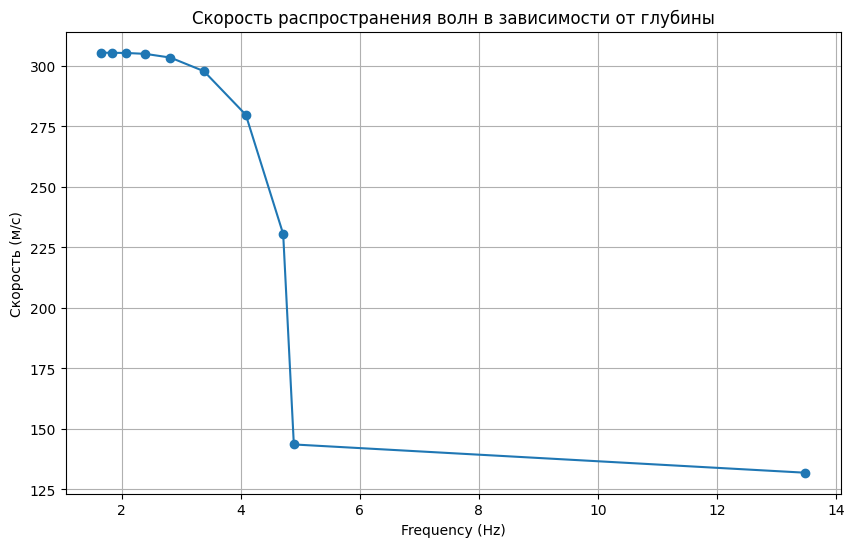

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(freq, data["Velocity"], marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

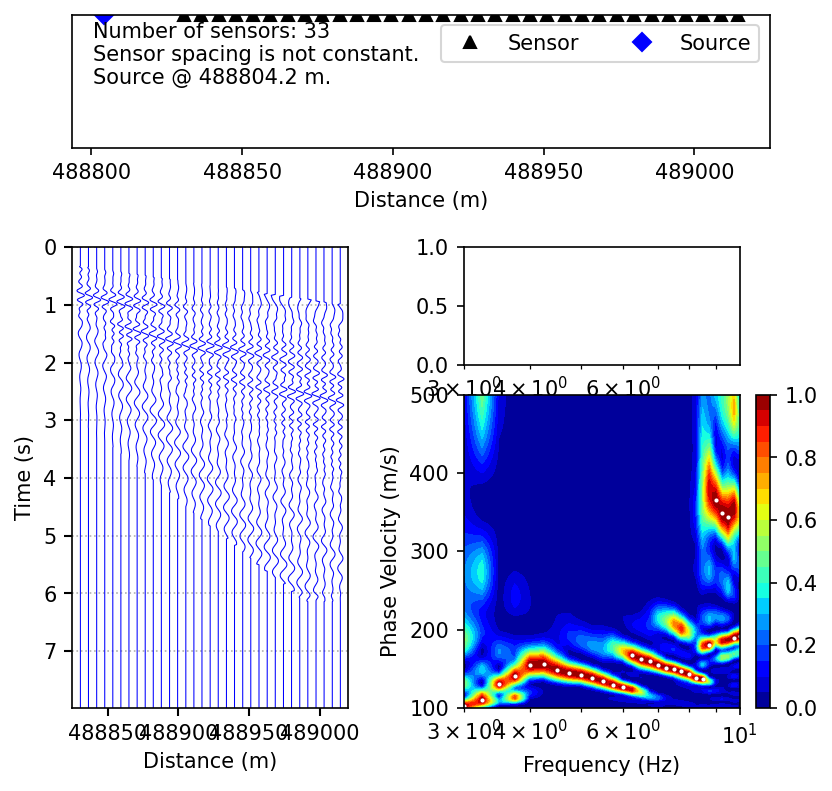

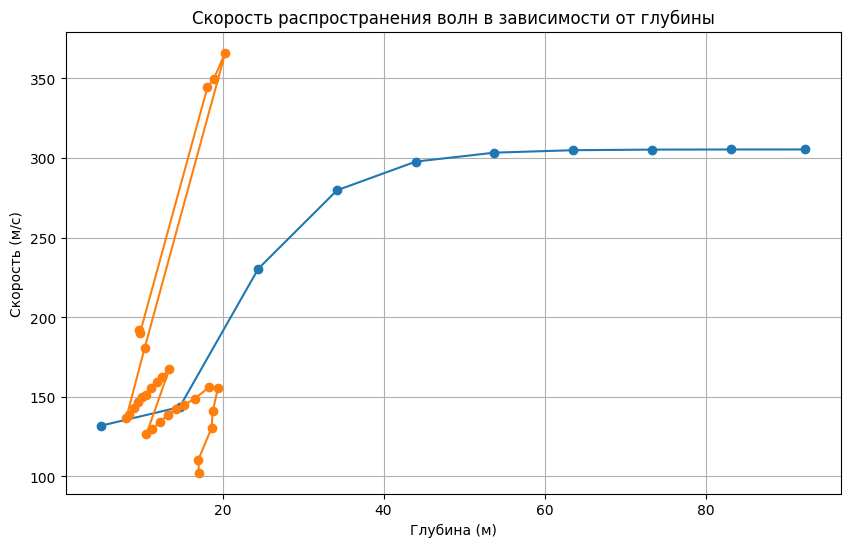

In [69]:
number = 1
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

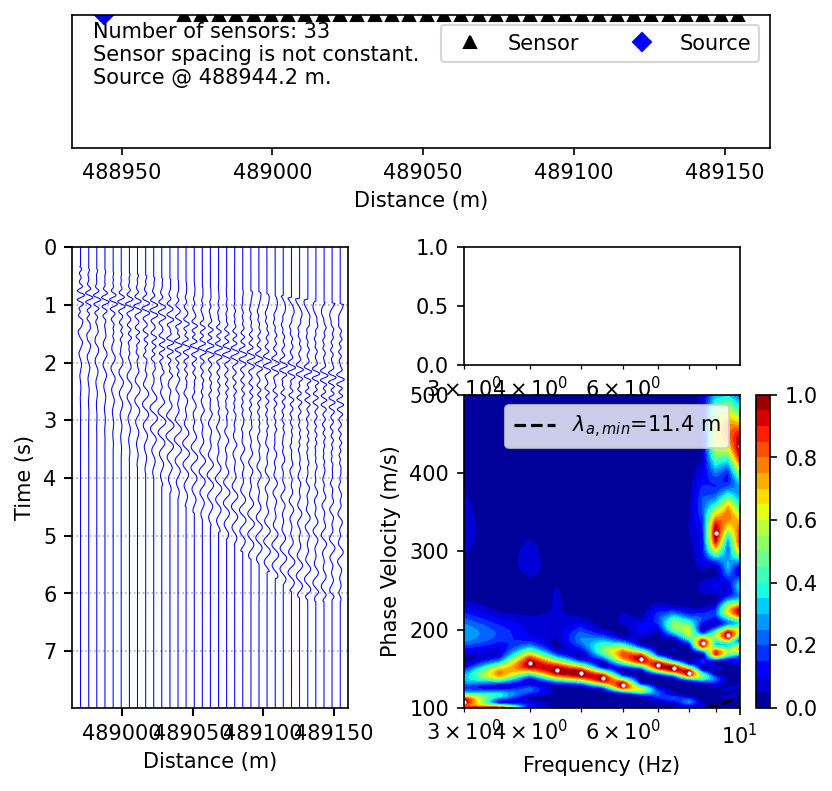

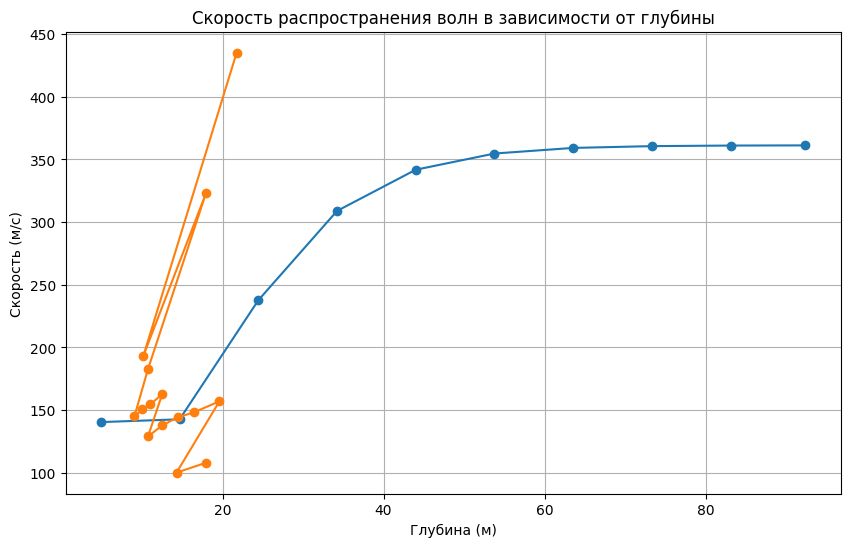

In [17]:
number = 2
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

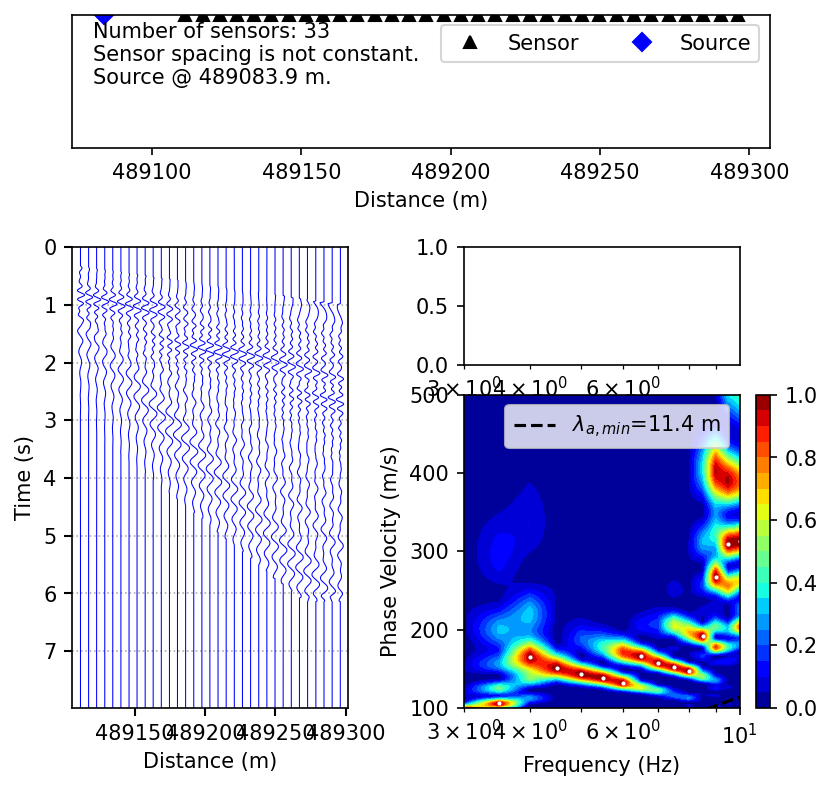

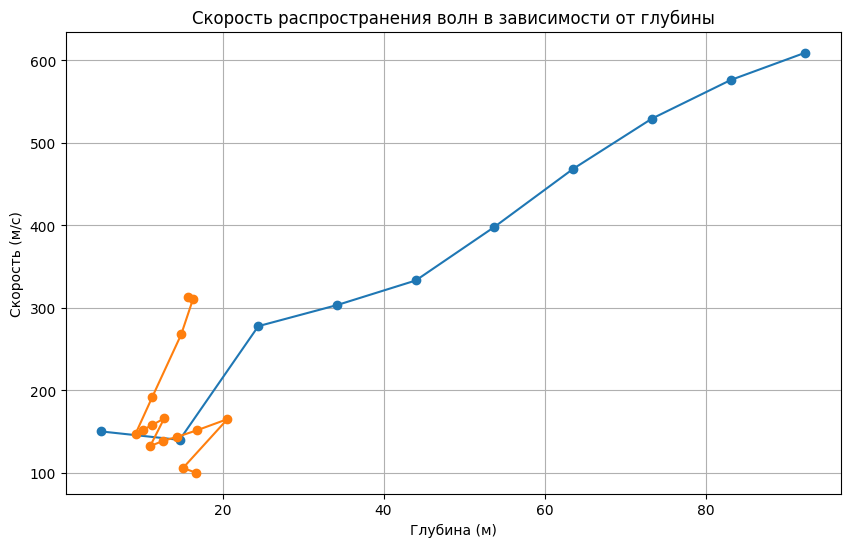

In [18]:
number = 3
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

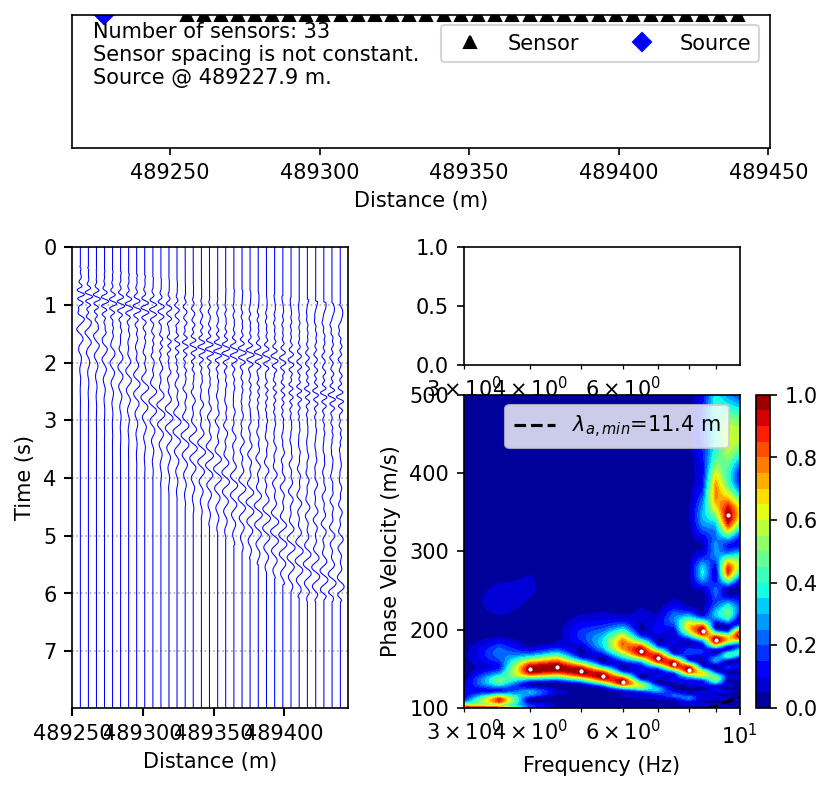

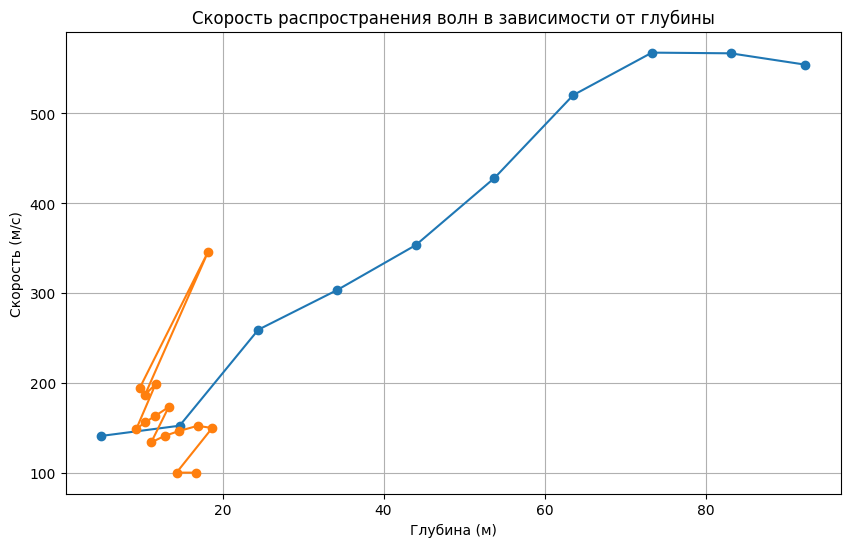

In [19]:
number = 4
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

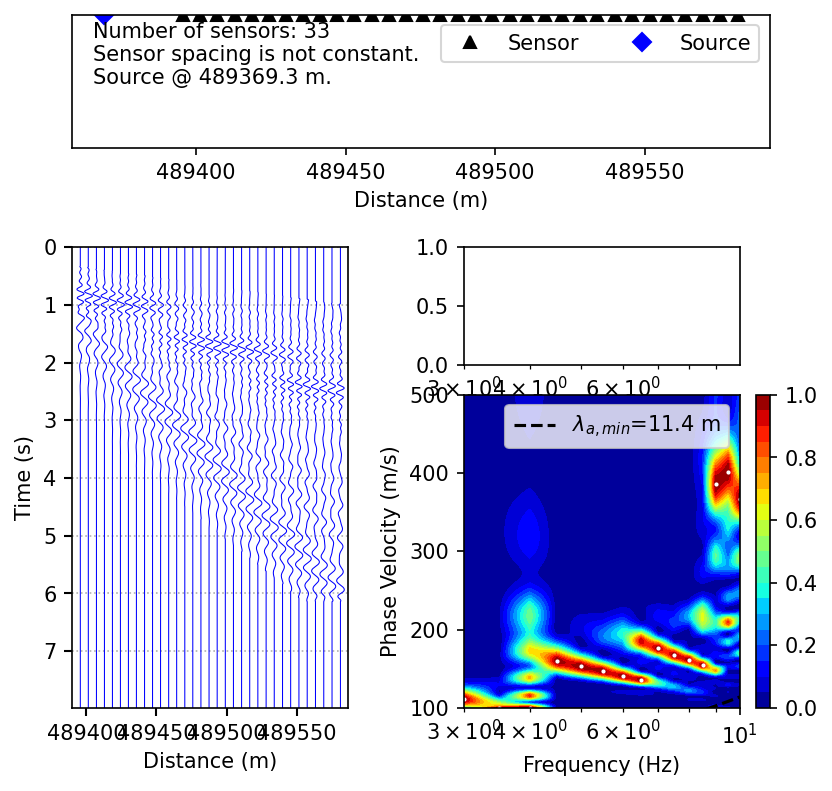

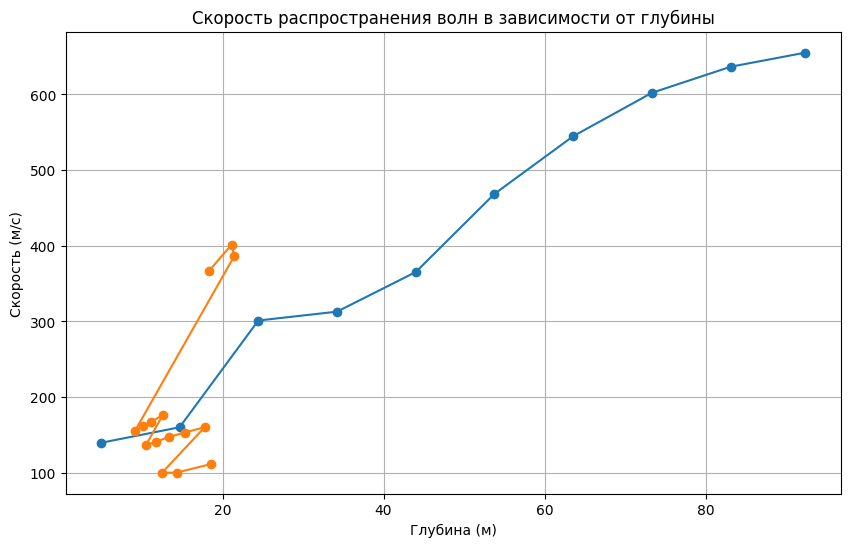

In [20]:
number = 5
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

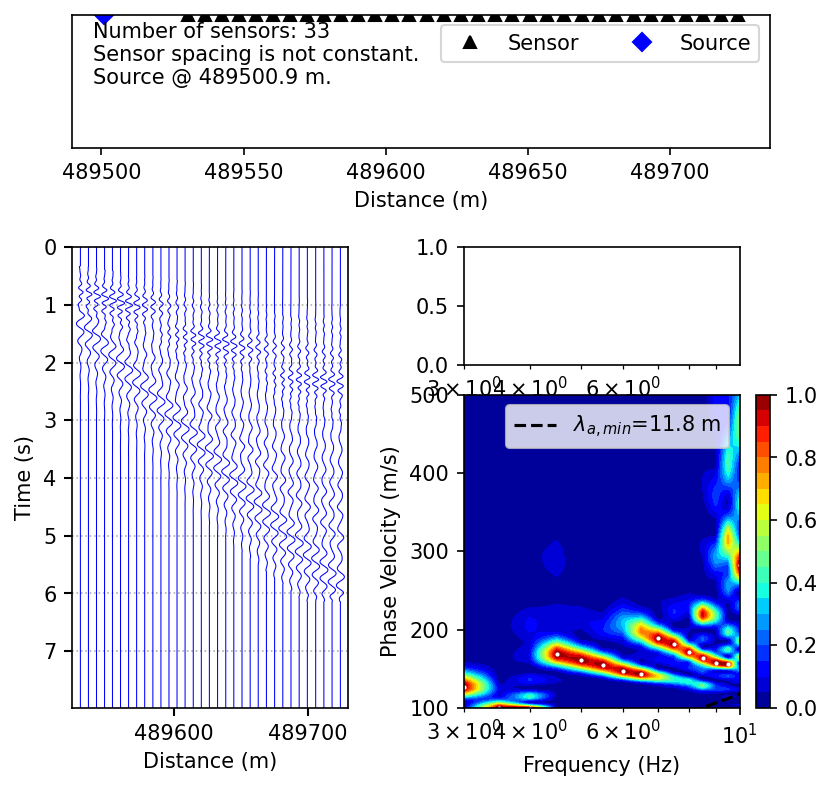

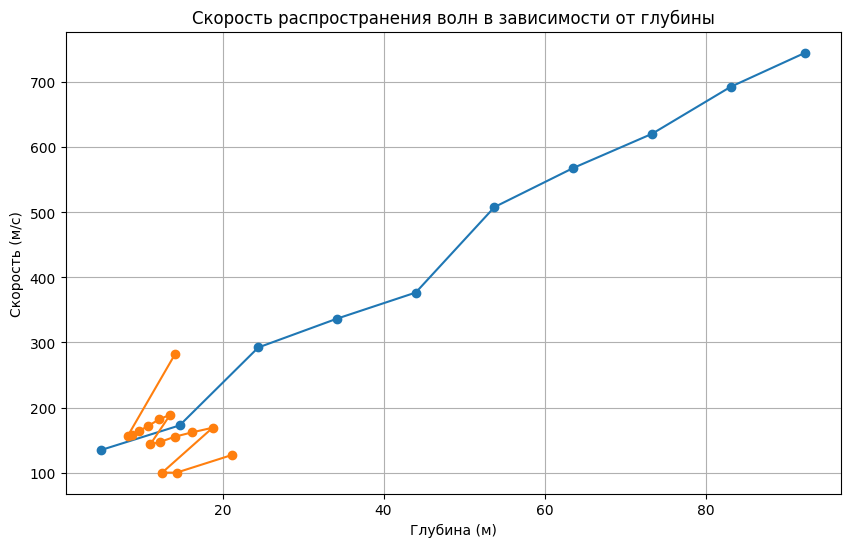

In [21]:
number = 6
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

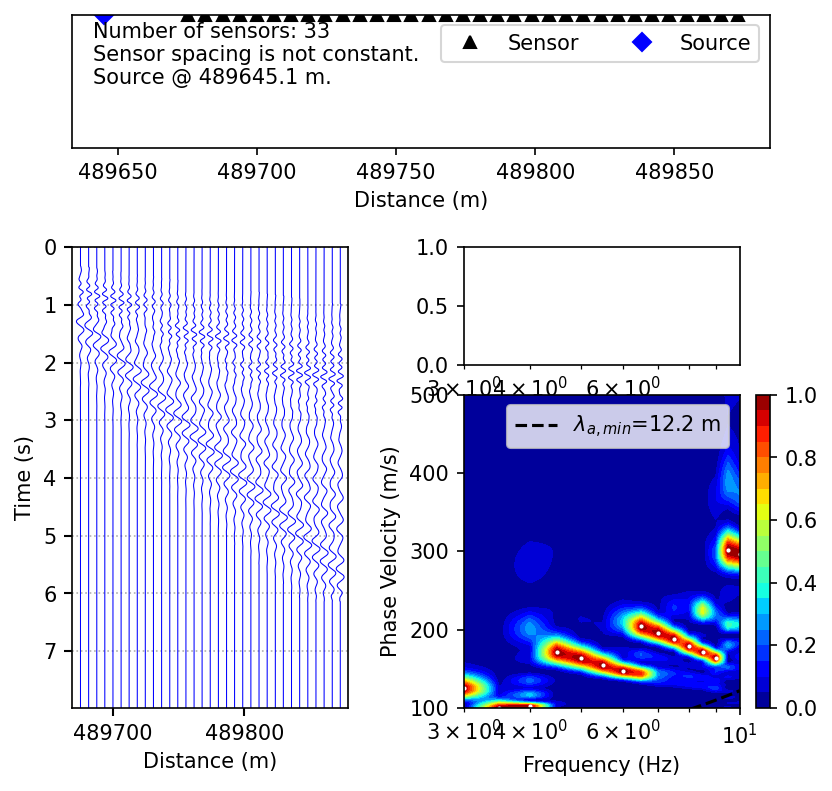

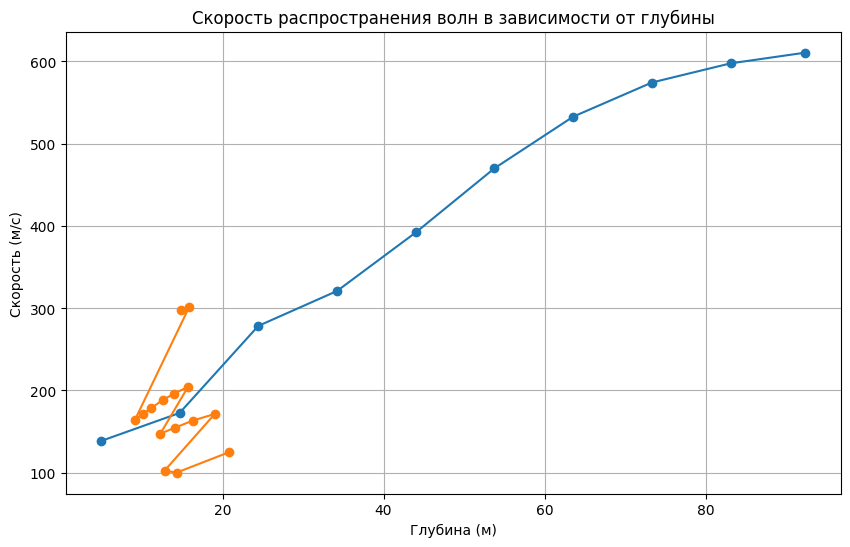

In [22]:
number = 7
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

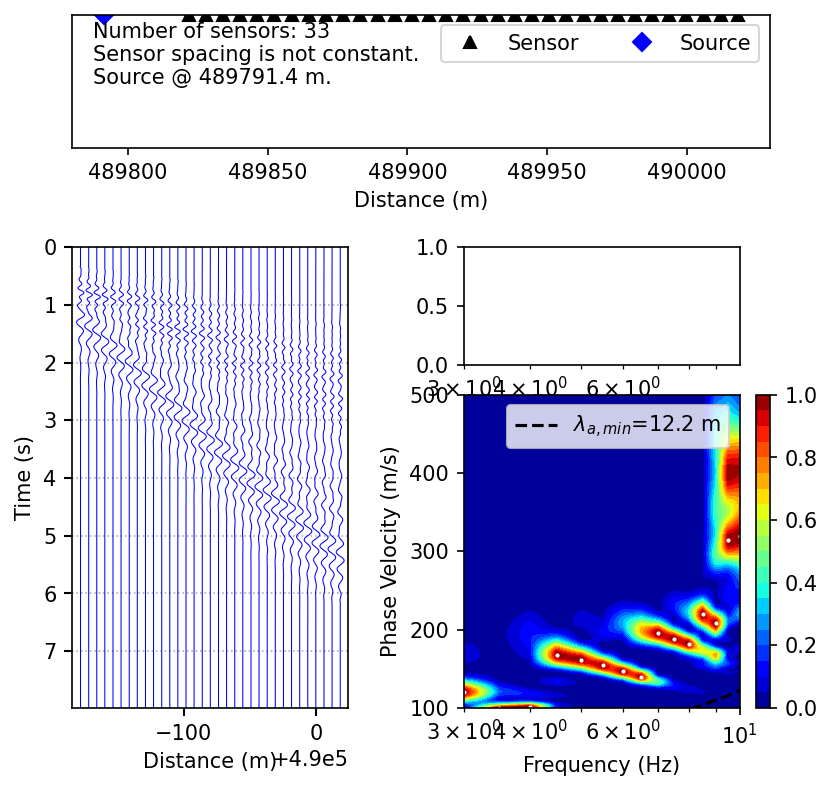

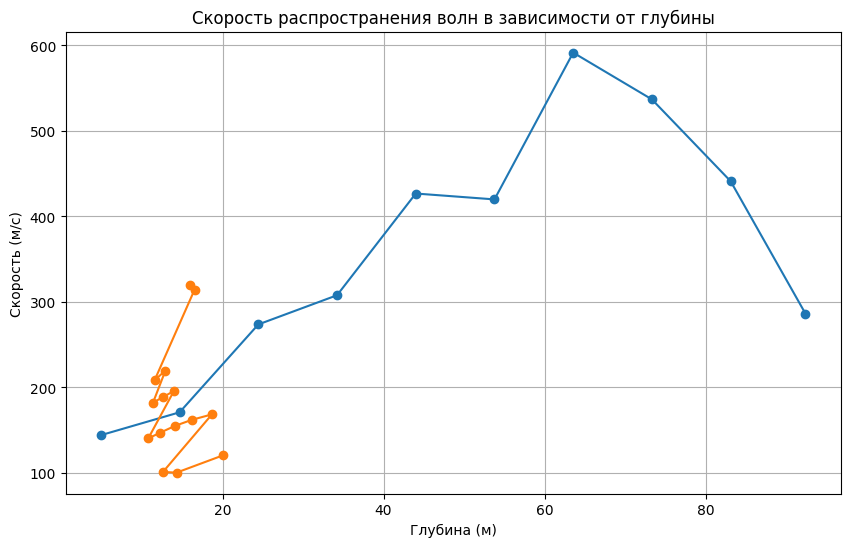

In [23]:
number = 8
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

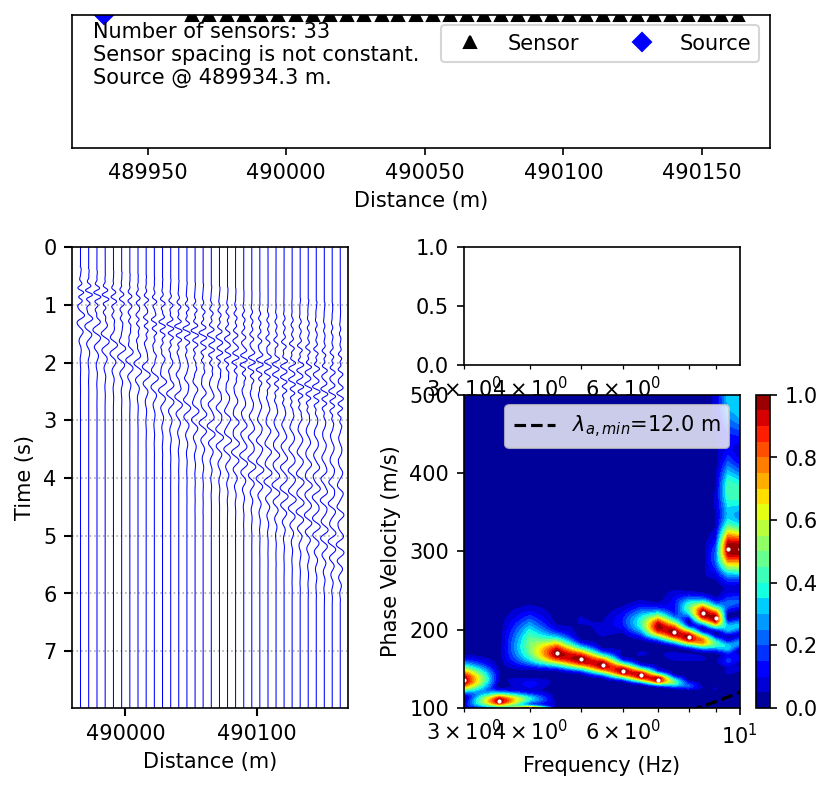

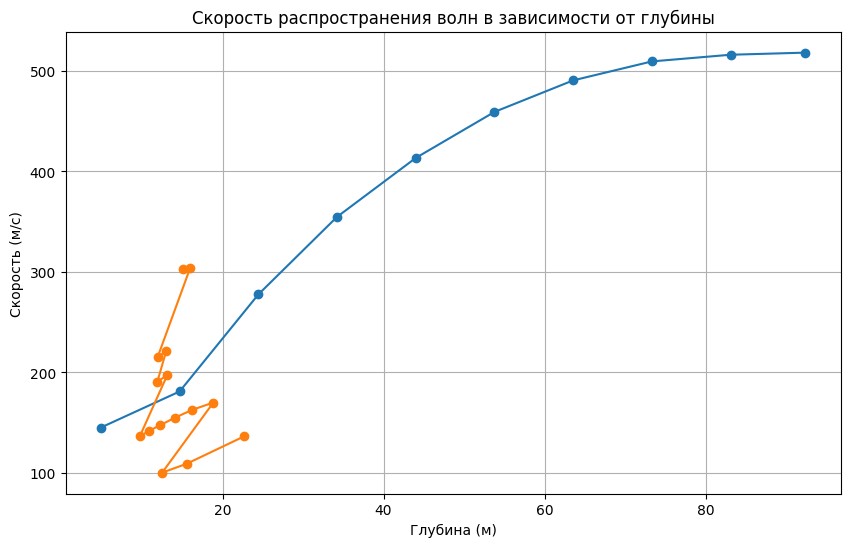

In [24]:
number = 9
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()